<a href="https://colab.research.google.com/github/eomtaehyeon/Hongong_ML-DL-/blob/main/Chapter_5_3_%EC%97%84%ED%83%9C%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - 3 트리의 앙상블
- LightGBM 기억!!
  + GBM --> XGBoost --> LightGBM
  + 참고 1. 모델개발속도가 빨라졌나?
  + 참고 2. 모델의 성능이 좋아졌나?
- TabNet(2019)
  + 딥러닝 컨셉!





## 랜덤 포레스트(Random Forest)
- 결정 트리 나무를 500개 심기
- 최종적인 결정은 투표 방식
  + 나무-1 : 양성
  + 나무-2 : 양성
  + 나무-3 : 음성
  ...
  + 나무-500 : 음성

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, 
                                                                      target, 
                                                                      test_size=0.2, 
                                                                      random_state=42)

- cross_validate() 교차 검증 수행
- n_jobs = -1 모든 CPU 코어를 사용.
- return_train_score = True : 검증 점수뿐만 아니라 훈련세트에 대한 점수도 반환.
  + 기본값 : False
  

In [2]:
%%time
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score = True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809
CPU times: user 235 ms, sys: 63 ms, total: 298 ms
Wall time: 5.74 s


In [3]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


- 결정트리에서 만든 특성 중요도와 비교
 [0.12345626 0.86862934 0.0079144 ]
: 당도의 중요도가 감소하고 알코올 도수와 pH특성의 중요도가 조금 상승

In [4]:
rf= RandomForestClassifier(oob_score = True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


- 랜덤 포레스트는 훈련 세트에서 중복을 허용하여 부트스트랩 샘플을 만들어 결정 트리를 훈련.
- OOB샘플 : 부트스트랩 샘플에 포함되지 않고 남는 샘플. 검증 세트의 역할

## 엑스트라 트리(Extra Trees)
- 랜덤포레스트와 매우 비슷하게 동작. 기본적으로 100개의 결정트리훈련.
- 부트스트랩 샘플을 사용하지 않음
- 랜덤포레스트와 비슷한 결과를 얻음.
- 계산속도가 빠르다.


In [5]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score = True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506
CPU times: user 62.5 ms, sys: 6.17 ms, total: 68.6 ms
Wall time: 4.53 s


In [6]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


## 그레이디언트 부스팅(Gradient Boosting)
- 경사하강법을 사용하여 트리를 앙상블에 추가
- 이전 트리의 오차를 보완하는 방식으로 사용.
- 깊이가 얕은 트리를 사용. 과대적합에 강함.
- 학습률 매개변수로 속도를 조절.
- 단점 : 속도가 느림.

In [7]:
# 기본적으로 깊이 3 결정트리 100개 learning_rate : 0.1
%%time
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score = True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))
gb.fit(train_input, train_target)
print(gb.feature_importances_)

0.8881086892152563 0.8720430147331015
[0.11949946 0.74871836 0.13178218]
CPU times: user 673 ms, sys: 6.92 ms, total: 680 ms
Wall time: 6.07 s


In [8]:
# 결정트리 500개, learning_rate : 0.2
%%time
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score = True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999
CPU times: user 180 ms, sys: 18 ms, total: 198 ms
Wall time: 22.8 s


In [9]:
gb.fit(train_input, train_target)
print(gb.feature_importances_)

[0.15872278 0.68010884 0.16116839]


- 결정 트리와 학습률을 늘렸지만 과대적합을 잘 억제함...
- 특성 중요도는 당도에 더 집중함.
- n_jobs 매개변수가 없음.

## 히스토그램 기반 그레이디언트 부스팅(Histogram-based Gradient Boosting)
- 입력 특성을 256개 구간으로 나눔. 노드분할할 때 빠름.
- 기본 매개변수에서 안정적인 성능을 얻음.
- n_estimators 대신에 max_iter를 사용해 부스팅 반복 횟수 지정.

In [10]:
# n_repeats 기본값 5

%%time
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target,
                        return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))


/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


0.9321723946453317 0.8801241948619236
CPU times: user 4.26 s, sys: 157 ms, total: 4.42 s
Wall time: 2.35 s


In [16]:
# permutation_importance() 함수 사용.
# n_repeats = 10
%%time
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target,
                                n_repeats=10, random_state=42, n_jobs=-1)
print(hgb.score(train_input, train_target))
print(result.importances_mean)

0.924956705791803
[0.08876275 0.23438522 0.08027708]
CPU times: user 5.46 s, sys: 56.8 ms, total: 5.52 s
Wall time: 10.6 s


In [12]:
result = permutation_importance(hgb, test_input, test_target,
                                n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


In [13]:
hgb.score(test_input, test_target)

0.8723076923076923

### XGBoost
- https://xgboost.ai/about

In [14]:
%%time
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target,
                        return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
xgb.fit(train_input, train_target)
print(xgb.feature_importances_)

0.8824322471423747 0.8726214185237284
[0.20026451 0.6175567  0.18217881]
CPU times: user 537 ms, sys: 26.9 ms, total: 564 ms
Wall time: 563 ms


### LightGBM
- https://github.com/microsoft/lightgbm

In [15]:
%%time
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state= 42)
scores = cross_validate(lgb, train_input, train_target, 
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
lgb.fit(train_input, train_target)
print(lgb.feature_importances_)

0.9338079582727165 0.8789710890649293
[ 947  991 1062]
CPU times: user 125 ms, sys: 6.13 ms, total: 131 ms
Wall time: 1.28 s


## 비교
- RandomForest(기본값) :
  + 0.9973541965122431 0.8905151032797809
  + [0.23167441 0.50039841 0.26792718]
  + CPU times: user 197 ms, sys: 46.4 ms, total: 243 ms
  + Wall time: 5.67 s
- ExtraTrees :
  + 0.9974503966084433 0.8887848893166506
  + [0.20183568 0.52242907 0.27573525]
  + CPU times: user 60.3 ms, sys: 8.35 ms, total: 68.7 ms
  + Wall time: 3.67 s
- GradientBoosting(기본값) : 
  + 0.8881086892152563 0.8720430147331015
  + [0.11949946 0.74871836 0.13178218]
  + CPU times: user 658 ms, sys: 7.5 ms, total: 665 ms
  + Wall time: 3.79 s
- GradientBoosting(결정트리 500개, learning_rate : 0.2) :
  + 0.9464595437171814 0.8780082549788999
  + [0.15872278 0.68010884 0.16116839]
  + CPU times: user 122 ms, sys: 12.6 ms, total: 134 ms
  + Wall time: 14 s
- Histogram-basedGradientBoosting :
  + 0.9321723946453317 0.8801241948619236
  + CPU times: user 4 s, sys: 170 ms, total: 4.17 s
  + Wall time: 2.17 s
- Histogram-basedGradientBoosting(n_repeats=10) : 
  + 0.924956705791803 0.8723076923076923
  + [0.08876275 0.23438522 0.08027708]
  + CPU times: user 5.46 s, sys: 56.8 ms, total: 5.52 s
  + Wall time: 10.6 s
- XGBoost :
  + 0.8824322471423747 0.8726214185237284
  + [0.20026451 0.6175567  0.18217881]
  + CPU times: user 573 ms, sys: 29.9 ms, total: 603 ms
  + Wall time: 607 ms
- LightGBM :
  + 0.9338079582727165 0.8789710890649293
  + [ 947  991 1062]
  + CPU times: user 130 ms, sys: 11.1 ms, total: 141 ms
  + Wall time: 1.47 s

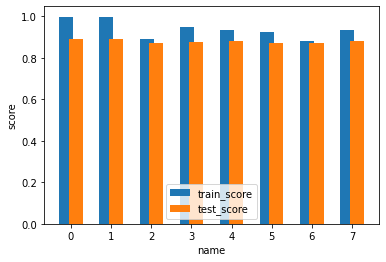

['RF', 'ET', 'GB', 'GB(500,0.2)', 'HGB', 'HGB(10)', 'XGB', 'LGBM']


In [59]:
import matplotlib.pyplot as plt
import numpy as np

name = ['RF','ET','GB','GB(500,0.2)','HGB','HGB(10)','XGB','LGBM']
train_score = [0.9973541965122431, 0.9974503966084433, 0.8881086892152563, 0.9464595437171814, 0.9321723946453317, 0.924956705791803, 0.8824322471423747, 0.9338079582727165]
test_score = [0.8905151032797809, 0.8887848893166506, 0.8720430147331015, 0.8780082549788999, 0.8801241948619236, 0.8723076923076923, 0.8726214185237284, 0.8789710890649293]

x = np.arange(len(name))   # the label locations
width = 0.35   # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, train_score, width, label='train_score')
rects2 = ax.bar(x + width/3, test_score, width, label='test_score')
ax.set_xlabel('name')
ax.set_ylabel('score')

ax.legend()

plt.show()
print(name)

# Reference :     
- XGBoost/about : https://xgboost.ai/about
- LightGBM : https://github.com/microsoft/lightgbm